In [7]:
# https://www.kaggle.com/datasets/ignaciovinuales/battery-remaining-useful-life-rul

In [8]:
########################################
# IMPORTS
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [9]:
battery_data = pd.read_csv(r'/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')

The Hawaii Natural Energy Institute examined 14 NMC-LCO 18650 batteries with a nominal capacity of 2.8 Ah, which were cycled over 1000 times at 25°C with a CC-CV charge rate of C/2 rate and discharge rate of 1.5C.

From that source dataset, I created features that showcase the voltage and current behaviour over each cycle. Those features can be used to predict the remaining useful life (RUL) of the batteries. The dataset contains the summary of the 14 batteries.

Variables:

Cycle Index: number of cycle
F1: Discharge Time (s)
F2: Time at 4.15V (s)
F3: Time Constant Current (s)
F4: Decrement 3.6-3.4V (s)
F5: Max. Voltage Discharge (V)
F6: Min. Voltage Charge (V)
F7: Charging Time (s)
Total time (s)
RUL: target

In [10]:
display(battery_data.iloc[577])

Cycle_Index                   599.000
Discharge Time (s)           1545.880
Decrement 3.6-3.4V (s)        463.125
Max. Voltage Dischar. (V)       3.910
Min. Voltage Charg. (V)         3.744
Time at 4.15V (s)            2807.250
Time constant current (s)    3752.000
Charging time (s)            8415.620
RUL                           514.000
Name: 577, dtype: float64

/tmp/ipykernel_383899/3840825520.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Informações Gerais do Dataset:
--------------------------------------------------
Número total de amostras: 15064
Número de features: 9

Descrição das features:
--------------------------------------------------
Cycle_Index               : Número do ciclo
Discharge Time (s)        : F1 - Tempo de descarga
Decrement 3.6-3.4V (s)    : F2 - Tempo de decremento entre 3.6V e 3.4V
Max. Voltage Dischar. (V) : F3 - Voltagem máxima de descarga
Min. Voltage Charg. (V)   : F4 - Voltagem mínima de carga
Time at 4.15V (s)         : F5 - Tempo em 4.15V
Time constant current (s) : F6 - Tempo de corrente constante
Charging time (s)         : F7 - Tempo de carga
RUL                       : Target - Vida útil restante

Estatísticas Descritivas:
--------------------------------------------------
        Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
count  15064.000000        15064.000000            15064.000000   
mean     556.155005         4581.273960             1239.784672   
std      32

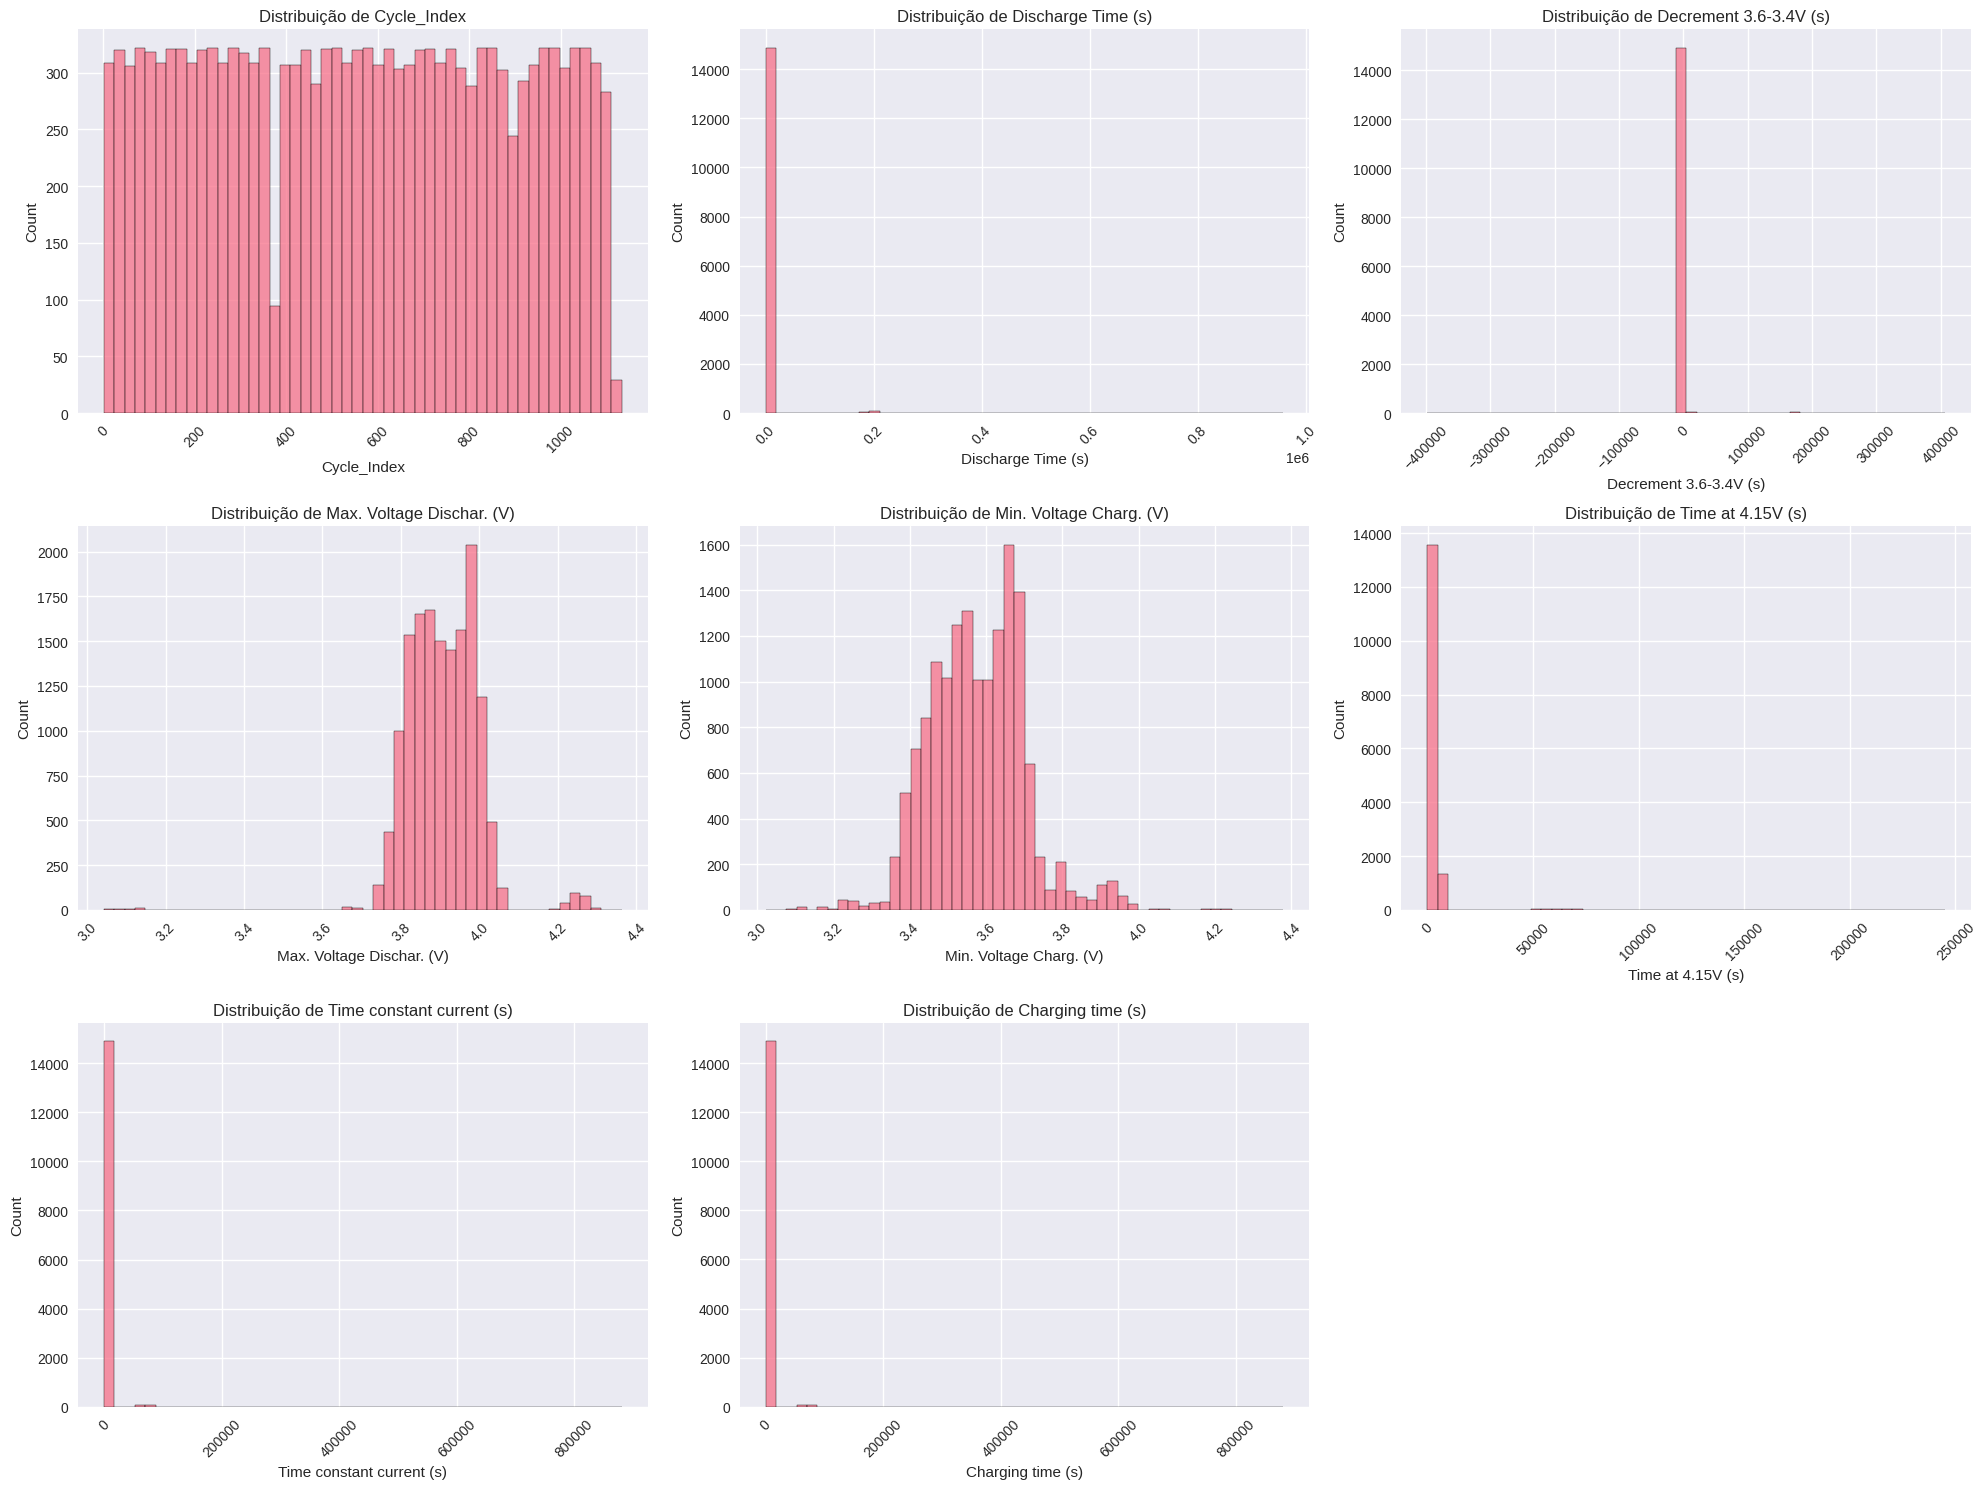

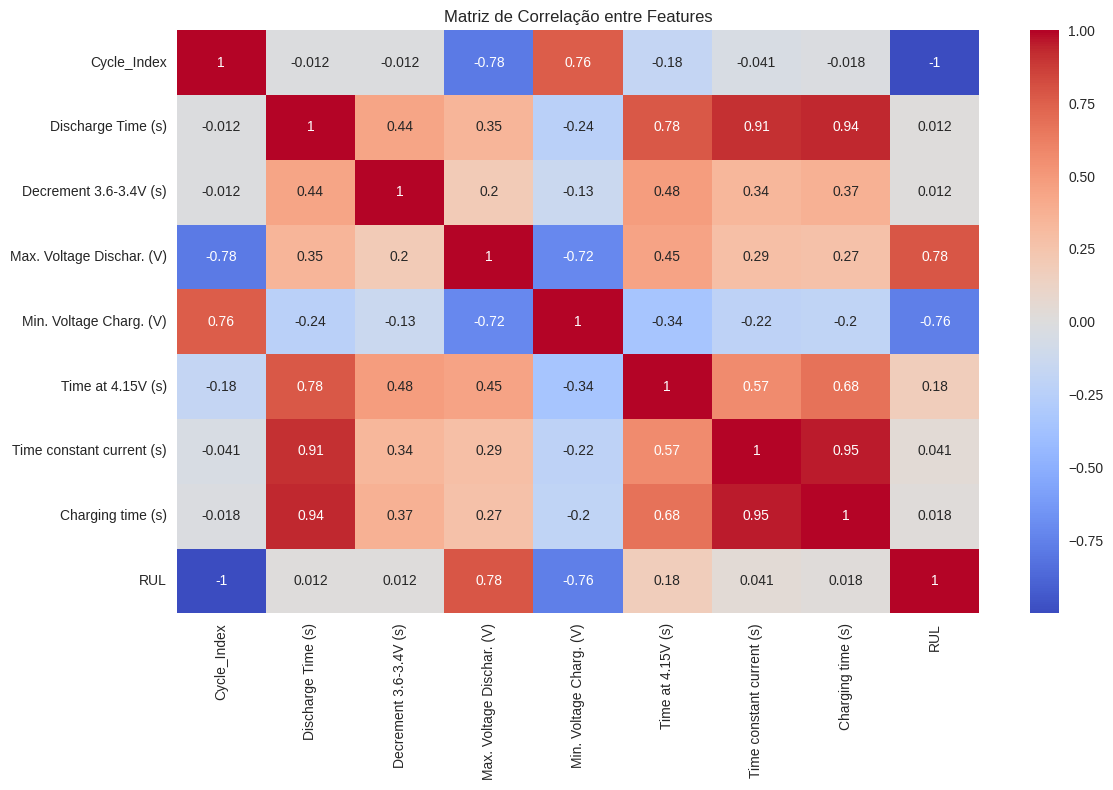

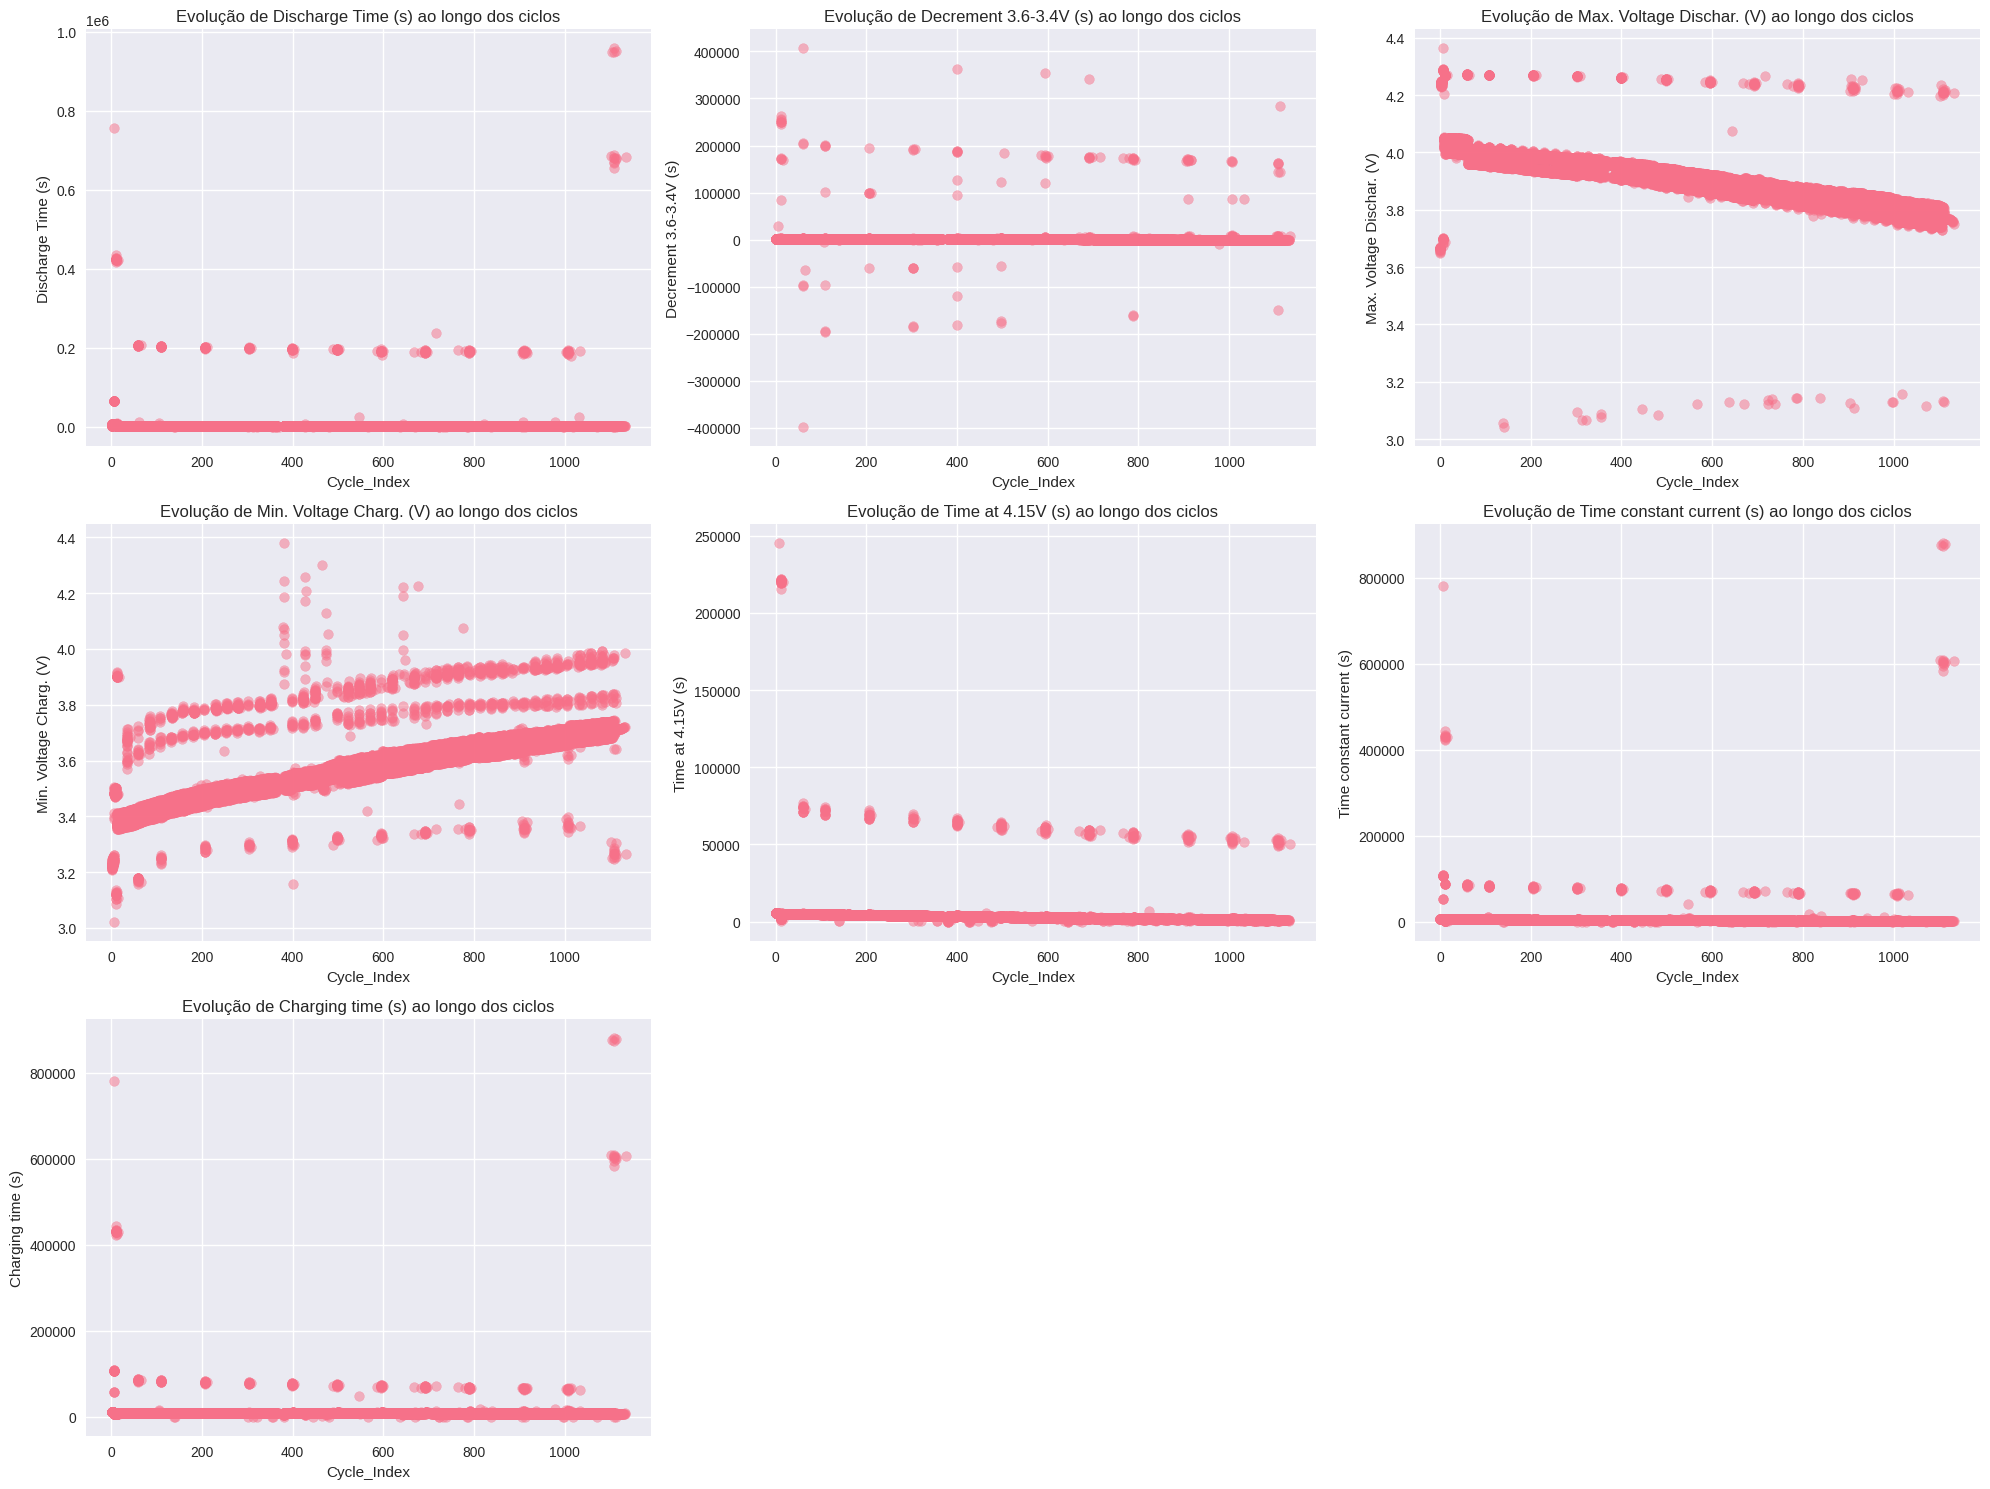

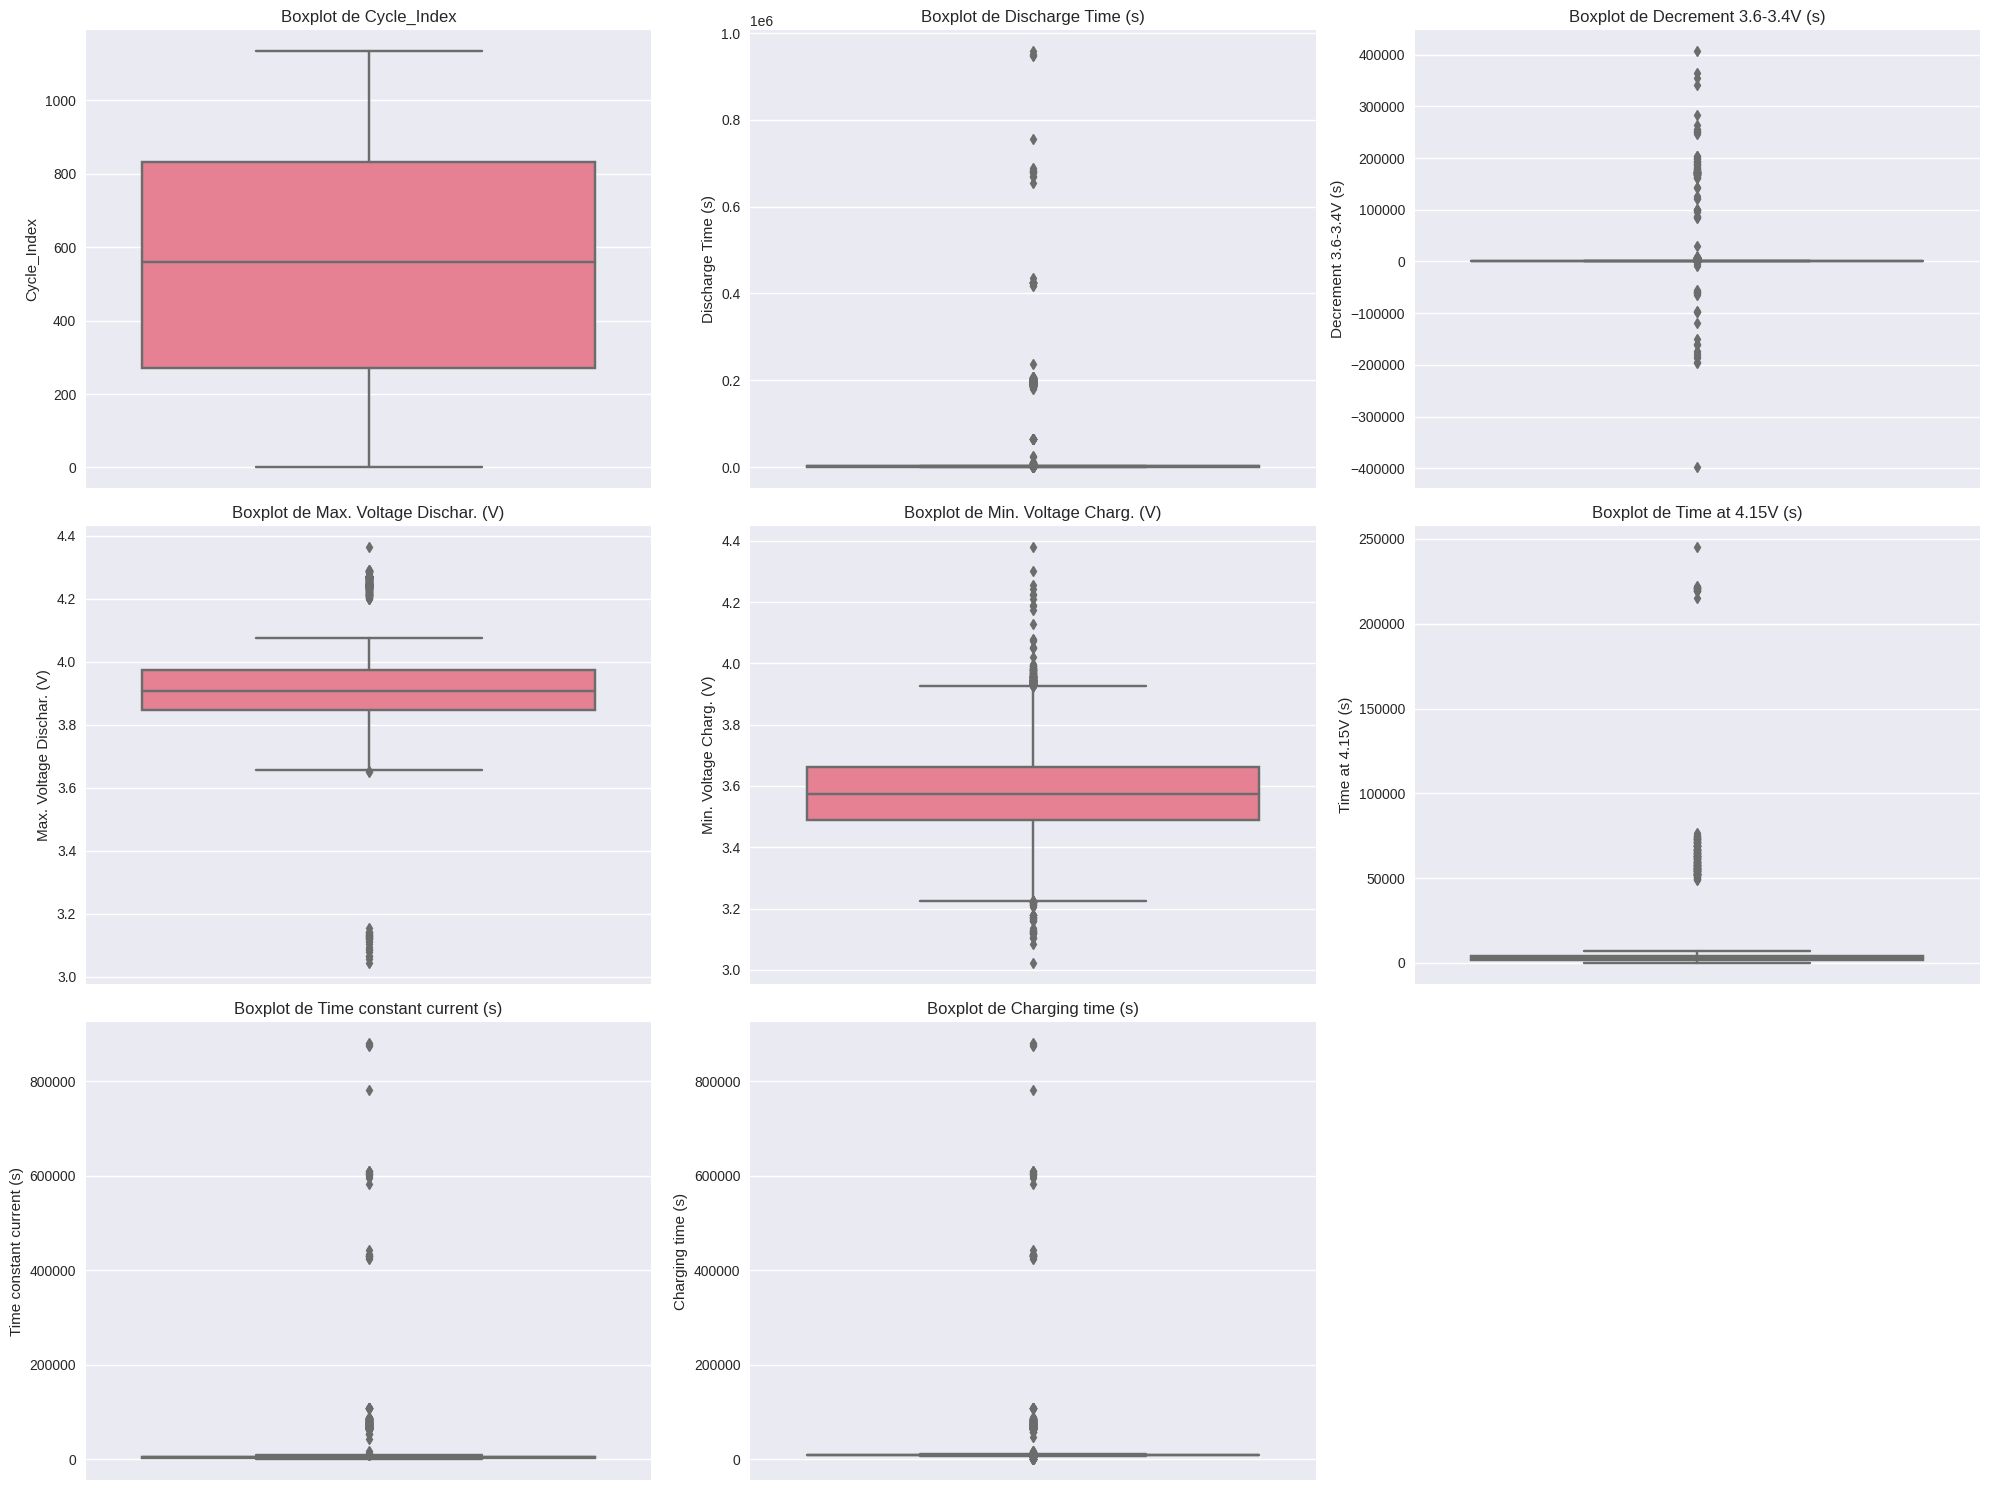


Estatísticas por Faixa de RUL:
--------------------------------------------------
          Discharge Time (s)               Decrement 3.6-3.4V (s)  \
                        mean           std                   mean   
RUL_faixa                                                           
0-10              872.145286    125.372274             218.319807   
11-100            939.101747     87.152714             243.120661   
101-500          3043.328179  18509.718123            1193.247610   
501-1000         3853.463899  19960.289483            1002.798039   
>1000            9757.828776  50374.205323            2758.446782   

                        Max. Voltage Dischar. (V)            \
                    std                      mean       std   
RUL_faixa                                                     
0-10          37.715227                  3.769057  0.080340   
11-100        32.067071                  3.789984  0.034392   
101-500    12992.351159                  3.852961

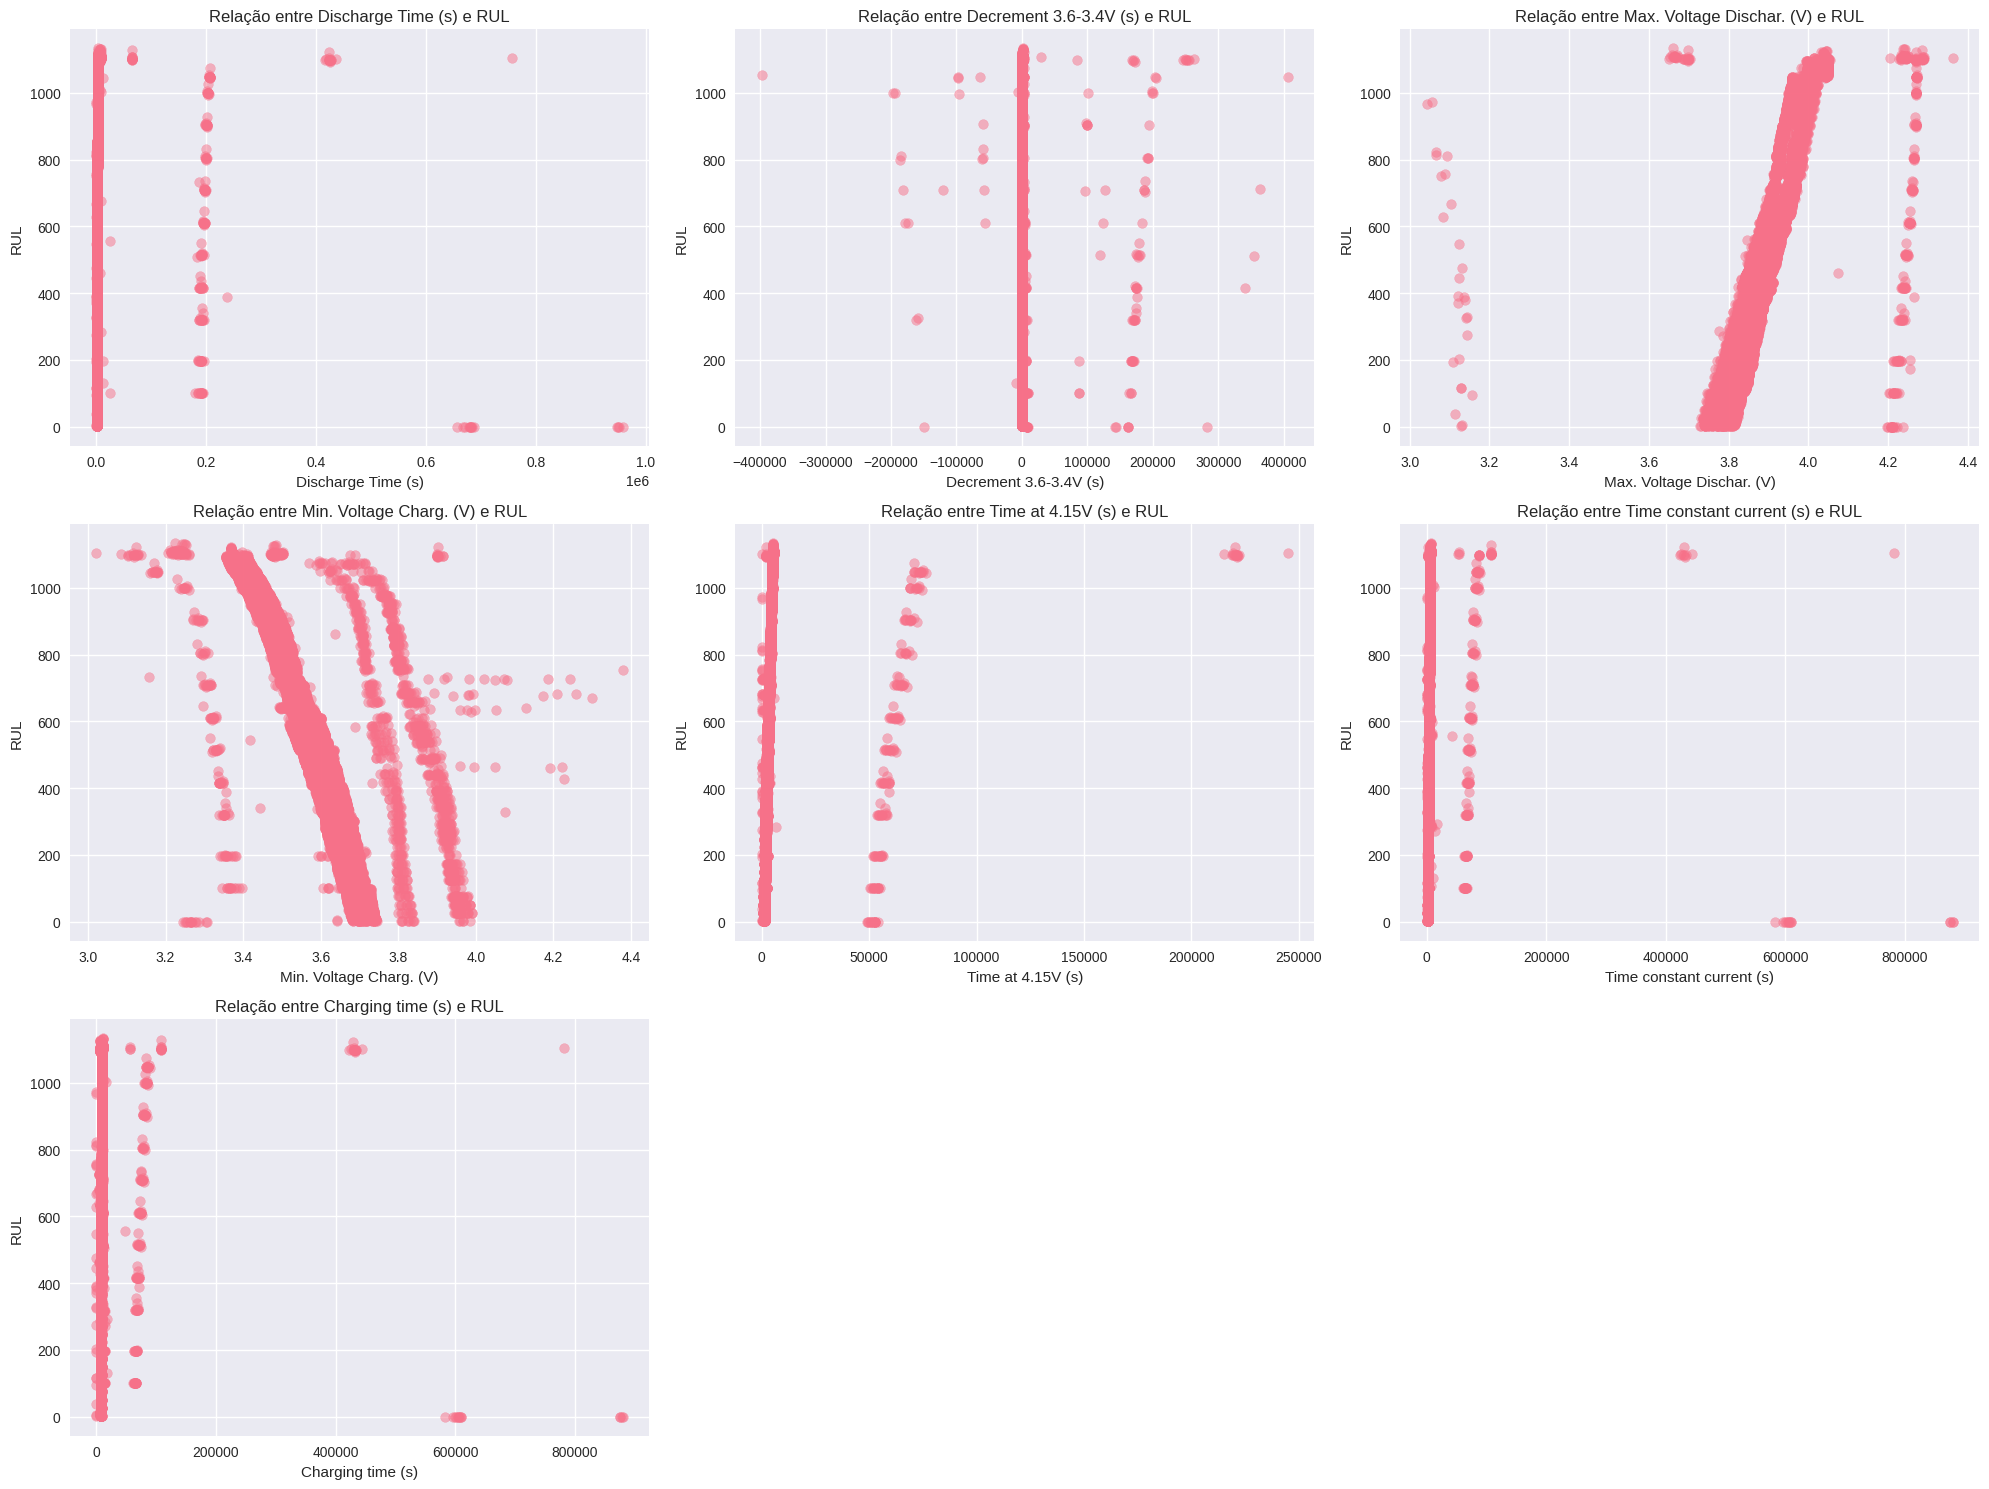


Correlações com RUL (ordenadas):
--------------------------------------------------
Cycle_Index                 -0.999756
Min. Voltage Charg. (V)     -0.759805
Discharge Time (s)           0.011957
Decrement 3.6-3.4V (s)       0.011998
Charging time (s)            0.018299
Time constant current (s)    0.040675
Time at 4.15V (s)            0.176514
Max. Voltage Dischar. (V)    0.782800
RUL                          1.000000
Name: RUL, dtype: float64


In [ ]:
# Análise Exploratória de Dados Detalhada
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette("husl")

print("Informações Gerais do Dataset:")
print("-" * 50)
print(f"Número total de amostras: {len(battery_data)}")
print(f"Número de features: {len(battery_data.columns)}")
print("\nDescrição das features:")
print("-" * 50)
features_desc = {
    'Cycle_Index': 'Número do ciclo',
    'Discharge Time (s)': 'F1 - Tempo de descarga',
    'Decrement 3.6-3.4V (s)': 'F2 - Tempo de decremento entre 3.6V e 3.4V',
    'Max. Voltage Dischar. (V)': 'F3 - Voltagem máxima de descarga',
    'Min. Voltage Charg. (V)': 'F4 - Voltagem mínima de carga',
    'Time at 4.15V (s)': 'F5 - Tempo em 4.15V',
    'Time constant current (s)': 'F6 - Tempo de corrente constante',
    'Charging time (s)': 'F7 - Tempo de carga',
    'RUL': 'Target - Vida útil restante'
}
for feature, desc in features_desc.items():
    print(f"{feature:25} : {desc}")

print("\nEstatísticas Descritivas:")
print("-" * 50)
print(battery_data.describe())

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[:-1], 1):  # Excluindo RUL
    plt.subplot(3, 3, i)
    sns.histplot(data=battery_data, x=feature, bins=50)
    plt.title(f'Distribuição de {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
correlation_matrix = battery_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação entre Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[1:-1], 1):  # Excluindo Cycle_Index e RUL
    plt.subplot(3, 3, i)
    plt.scatter(battery_data['Cycle_Index'], battery_data[feature], alpha=0.5)
    plt.title(f'Evolução de {feature} ao longo dos ciclos')
    plt.xlabel('Cycle_Index')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[:-1], 1):  # Excluindo RUL
    plt.subplot(3, 3, i)
    sns.boxplot(y=battery_data[feature])
    plt.title(f'Boxplot de {feature}')
plt.tight_layout()
plt.show()

bins = [0, 10, 100, 500, 1000, float('inf')]
labels = ['0-10', '11-100', '101-500', '501-1000', '>1000']
battery_data['RUL_faixa'] = pd.cut(battery_data['RUL'], bins=bins, labels=labels)

# Estatísticas por faixa de RUL
print("\nEstatísticas por Faixa de RUL:")
print("-" * 50)
rul_stats = battery_data.groupby('RUL_faixa')[battery_data.columns[1:-2]].agg(['mean', 'std'])
print(rul_stats)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[1:-2], 1):  # Excluindo Cycle_Index e RUL_faixa
    plt.subplot(3, 3, i)
    plt.scatter(battery_data[feature], battery_data['RUL'], alpha=0.5)
    plt.title(f'Relação entre {feature} e RUL')
    plt.xlabel(feature)
    plt.ylabel('RUL')
plt.tight_layout()
plt.show()

correlations = battery_data[battery_data.columns[:-1]].corr()['RUL'].sort_values()
print("\nCorrelações com RUL (ordenadas):")
print("-" * 50)
print(correlations)

# Análise Exploratória de Dados - Bateria RUL

## Visão Geral do Dataset

A análise exploratória dos dados de vida útil restante (RUL) de baterias revelou padrões e características importantes para o desenvolvimento do modelo preditivo. O dataset contém medições de diferentes parâmetros ao longo dos ciclos de vida das baterias, incluindo tempos de carga/descarga, voltagens e outras métricas operacionais.

## Distribuições e Características das Features

A análise das distribuições individuais mostrou comportamentos distintos entre as features. O Cycle_Index apresenta uma distribuição relativamente uniforme entre 0-1200 ciclos, com uma queda notável por volta do ciclo 400. As métricas temporais (Discharge Time, Time at 4.15V, Time constant current e Charging time) exibem distribuições altamente assimétricas, com forte concentração em valores baixos e presença de outliers extremos. Já as medidas de voltagem (Max. Voltage Dischar. e Min. Voltage Charg.) apresentam distribuições mais regulares, com a voltagem máxima de descarga seguindo uma distribuição aproximadamente normal centrada em 3.9V e a voltagem mínima de carga mostrando um padrão bimodal com picos em torno de 3.5V e 3.8V.

## Correlações e Relações com RUL

A análise de correlação revelou que as variáveis de voltagem são os preditores mais promissores para o RUL. O Max. Voltage Dischar. apresenta uma forte correlação positiva (0.78) com o RUL, enquanto o Min. Voltage Charg. mostra uma correlação negativa significativa (-0.76). O Cycle_Index, como esperado, tem correlação perfeita negativa (-1.0) com o RUL, mas sua utilidade prática é limitada para previsões reais. As demais variáveis temporais mostram correlações mais fracas, com o Time at 4.15V apresentando uma correlação positiva modesta (0.18).

## Evolução Temporal e Degradação

A análise da evolução temporal das features revelou padrões claros de degradação. A voltagem máxima de descarga mostra uma tendência decrescente consistente, diminuindo de aproximadamente 4.0V para 3.8V ao longo dos ciclos. Em contraste, a voltagem mínima de carga apresenta uma tendência crescente gradual, aumentando de 3.4V para 3.8V. As métricas temporais (Discharge Time, Time at 4.15V, Charging time e Time constant current) mantêm-se relativamente estáveis ao longo dos ciclos, mas apresentam outliers significativos, especialmente nos ciclos finais.

## Outliers e Qualidade dos Dados

A análise de boxplots revelou a presença significativa de outliers em várias features, particularmente nas métricas temporais. Discharge Time, Decrement 3.6-3.4V, Time at 4.15V, Time constant current e Charging time apresentam valores extremos que se desviam substancialmente do padrão geral dos dados. Estes outliers podem representar tanto eventos reais de degradação quanto possíveis erros de medição, necessitando uma estratégia cuidadosa de tratamento.

## Implicações para Modelagem

Com base na análise exploratória, exitem algumas diretrizes para o desenvolvimento do modelo:

1. Priorizar as features de voltagem como principais preditores, dado seu forte poder preditivo
2. Implementar um tratamento robusto de outliers, especialmente para as métricas temporais
3. Considerar transformações não-lineares para features com distribuições altamente assimétricas
4. Avaliar a criação de features derivadas, especialmente combinando diferentes medidas de voltagem
5. Aplicar técnicas de normalização/escalonamento devido às diferentes escalas das features
6. Potencialmente remover ou transformar features com baixa correlação com o RUL

## Conclusão

A análise exploratória sugere que um modelo efetivo para previsão de RUL deve se basear principalmente nas medidas de voltagem, incorporando um tratamento robusto de outliers e possíveis transformações não-lineares dos dados. A presença de padrões claros de degradação nas voltagens indica que estas features podem fornecer sinais confiáveis para a previsão da vida útil restante das baterias.

/tmp/ipykernel_383899/1750281146.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


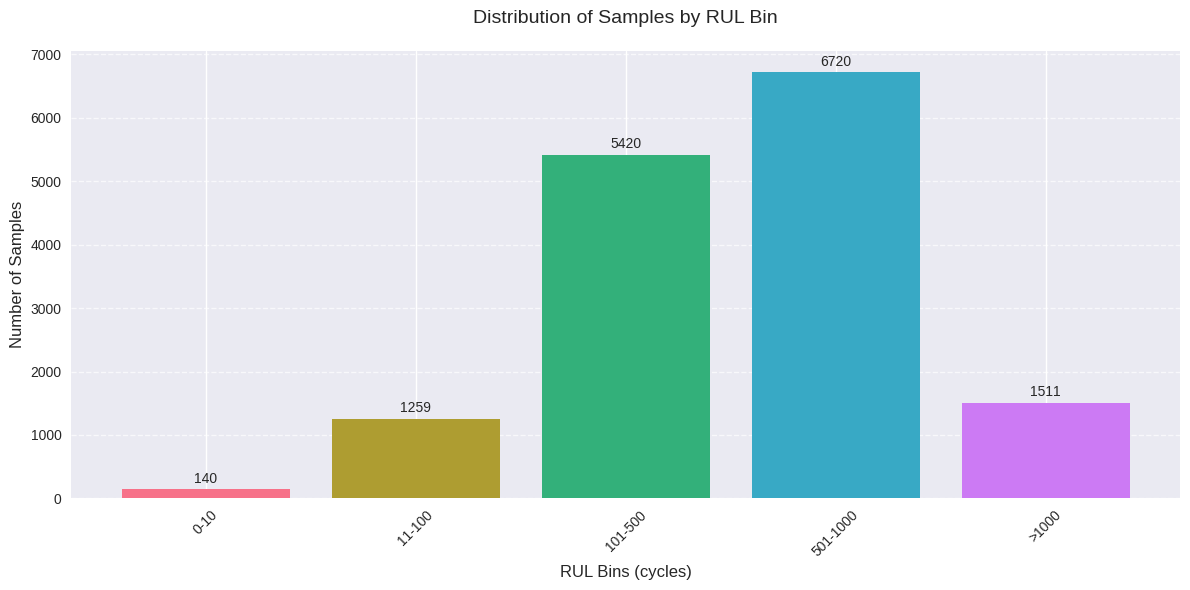


Statistics by RUL bin:
Bin 0-10    :   140 samples (  0.9%)
Bin 11-100  :  1259 samples (  8.4%)
Bin 101-500 :  5420 samples ( 36.0%)
Bin 501-1000:  6720 samples ( 44.6%)
Bin >1000   :  1511 samples ( 10.0%)


In [ ]:

plt.style.use('seaborn')
plt.figure(figsize=(12, 6))

bins = [0, 10, 100, 500, 1000, float('inf')]
labels = ['0-10', '11-100', '101-500', '501-1000', '>1000']
battery_data['RUL_faixa'] = pd.cut(battery_data['RUL'], bins=bins, labels=labels)

rul_counts = battery_data['RUL_faixa'].value_counts().sort_index()

colors = sns.color_palette("husl", 5)
plt.bar(range(len(rul_counts)), rul_counts.values, color=colors)

plt.title('Distribution of Samples by RUL Bin', fontsize=14, pad=20)
plt.xlabel('RUL Bins (cycles)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(range(len(labels)), labels, rotation=45)

for i, v in enumerate(rul_counts.values):
    plt.text(i, v + 100, str(v), ha='center', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nStatistics by RUL bin:")
for faixa, count in rul_counts.items():
    percentage = (count/len(battery_data))*100
    print(f"Bin {faixa:8}: {count:5} samples ({percentage:5.1f}%)")

# Exploratory Data Analysis of Battery RUL Dataset

The analysis of the battery RUL dataset revealed important characteristics and challenges that explain the current performance of the predictive model. The dataset contains 15,064 records, with RUL values ranging from 0 to 1,133 cycles, showing an average of 554 cycles and a standard deviation of 322 cycles.

One of the most critical aspects identified is the significant imbalance in the data distribution. Most samples are concentrated in the RUL range between 501-1000 cycles (6,720 samples) and 101-500 cycles (5,420 samples). In contrast, there are only 140 samples for very low RULs (0-10 cycles) and 1,259 samples for RULs between 11-100 cycles. This imbalance explains partially why the model has difficulty making accurate predictions for batteries nearing the end of life.

The correlation analysis between features and RUL revealed that only two variables exhibit strong correlations: the maximum discharge voltage (positive correlation of 0.78) and the minimum charge voltage (negative correlation of -0.76). The other features show surprisingly low correlations, with values below 0.18, suggesting that many currently used variables may not be good predictors of RUL.

A particularly concerning issue identified in the data of end-of-life (RUL = 0) is that these records exhibit anomalous values in several features, with measurements orders of magnitude larger than the dataset average. For example, the discharge time shows values exceeding 670,000 seconds, while the average for other RUL ranges is typically below 10,000 seconds. These anomalies are likely measurement or recording errors and are significantly contributing to the high error in end-of-life predictions.

The analysis of the average values of features by RUL bin shows clear degradation trends, but also highlights the inconsistency of the data for low RULs. For example, the average discharge time drops from 9,757 seconds for new batteries (RUL > 1000) to just 872 seconds for batteries nearing the end of life (RUL 0-10), a reduction that appears to follow a logical pattern. However, other metrics show less consistent variations or even contradictory trends.

To improve the quality of predictions, especially for low RULs, several corrective measures will be necessary. First, it is essential to perform data cleaning to remove or correct the anomalies identified. Next, techniques for data balancing, such as SMOTE (Synthetic Minority Over-sampling Technique), can be applied to balance the representation of different RUL bins. Additionally, new derived features can be created to better capture the relationships between existing variables and the battery degradation process.


Finally, it is recommended to implement a stratified training strategy to ensure that all RUL bins are adequately represented during model training. These modifications should result in a more robust model capable of making more accurate predictions throughout the battery's entire life, especially in critical states near the end of life.




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def clean_dataset(df):
    print("Original dataset size:", len(df))
    
    stats = df.describe()
    
    df_clean = df.copy()
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 
                'Time constant current (s)', 'Charging time (s)']
    
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        

        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) & 
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Size after removing anomalies:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    min_size = df.groupby('RUL_bin').size().min()
    max_size = df.groupby('RUL_bin').size().max()
    print("Size of the smallest class:", min_size)
    print("Size of the largest class:", max_size)
    
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    df_balanced = pd.concat(balanced_samples)
    df_balanced = df_balanced.drop('RUL_bin', axis=1)
    
    print("\nSize of the dataset after balancing:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)',
                'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)',
                'Charging time (s)', 'voltage_range', 'charging_efficiency', 
                'voltage_decay_rate', 'charging_speed']
    
    X = df[features].values
    y = df['RUL'].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Iniciando processamento do dataset...")
    
    print("\nStep 1: Cleaning the data")
    df_clean = clean_dataset(df)
    
    print("\nStep 2: Creating new features")
    df_featured = create_features(df_clean)
    print("New features created:", 
          [col for col in df_featured.columns if col not in df_clean.columns])
    
    print("\nStep 3: Balancing the dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    print("\nStep 4: Data preparation")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    print("\nStep 5: Train/test split")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')
X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

df_processed = create_features(clean_dataset(battery_data))
correlations = df_processed.corr()['RUL'].sort_values()
print("\nCorrelations with RUL (including new features):")
print(correlations)

np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)

Iniciando processamento do dataset...

Step 1: Cleaning the data
Original dataset size: 15064
Size after removing anomalies: 14615

Step 2: Creating new features
New features created: ['voltage_range', 'charging_efficiency', 'voltage_decay_rate', 'charging_speed']

Step 3: Balancing the dataset
Size of the smallest class: 1452
Size of the largest class: 1473

Size of the dataset after balancing: 14520

Step 4: Data preparation

Step 5: Train/test split
Original dataset size: 15064
Size after removing anomalies: 14615

Correlations with RUL (including new features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4.15V (s)            0.985559
Discharge 

Modelo corrigido 

In [14]:
df_processed.iloc[554]

Cycle_Index                   599.000000
Discharge Time (s)           1545.880000
Decrement 3.6-3.4V (s)        463.125000
Max. Voltage Dischar. (V)       3.910000
Min. Voltage Charg. (V)         3.744000
Time at 4.15V (s)            2807.250000
Time constant current (s)    3752.000000
Charging time (s)            8415.620000
RUL                           514.000000
voltage_range                   0.166000
charging_efficiency             5.443903
voltage_decay_rate              0.299587
charging_speed                  0.445838
Name: 577, dtype: float64

Iniciando processamento do dataset...

Etapa 1: Limpeza dos dados
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Etapa 2: Criação de novas features
Novas features criadas: ['voltage_range', 'charging_speed', 'charging_efficiency', 'voltage_decay_rate']

Etapa 3: Balanceamento do dataset

Tamanho do dataset após balanceamento: 14520

Etapa 4: Preparação dos dados (escalonamento)

Etapa 5: Divisão treino/teste
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Correlações com RUL (incluindo novas features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4.15V (s)            0.985559
Discharge Time 

/home/romulo/.local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/50 | Train Loss=0.0805 | Val Loss=0.0068 | LR=0.000167
Epoch 2/50 | Train Loss=0.0120 | Val Loss=0.0068 | LR=0.000333
Epoch 3/50 | Train Loss=0.0092 | Val Loss=0.0024 | LR=0.000500
Epoch 4/50 | Train Loss=0.0073 | Val Loss=0.0018 | LR=0.000500
Epoch 5/50 | Train Loss=0.0051 | Val Loss=0.0015 | LR=0.000500
Epoch 6/50 | Train Loss=0.0044 | Val Loss=0.0031 | LR=0.000500
Epoch 7/50 | Train Loss=0.0041 | Val Loss=0.0018 | LR=0.000500
Epoch 8/50 | Train Loss=0.0036 | Val Loss=0.0018 | LR=0.000500
Epoch 9/50 | Train Loss=0.0033 | Val Loss=0.0020 | LR=0.000500
Epoch 10/50 | Train Loss=0.0031 | Val Loss=0.0016 | LR=0.000500
Epoch 11/50 | Train Loss=0.0030 | Val Loss=0.0021 | LR=0.000250
Epoch 12/50 | Train Loss=0.0026 | Val Loss=0.0014 | LR=0.000250
Epoch 13/50 | Train Loss=0.0025 | Val Loss=0.0022 | LR=0.000250
Epoch 14/50 | Train Loss=0.0025 | Val Loss=0.0024 | LR=0.000250
Epoch 15/50 | Train Loss=0.0024 | Val Loss=0.0015 | LR=0.000250
Epoch 16/50 | Train Loss=0.0024 | Val Loss=0.0015

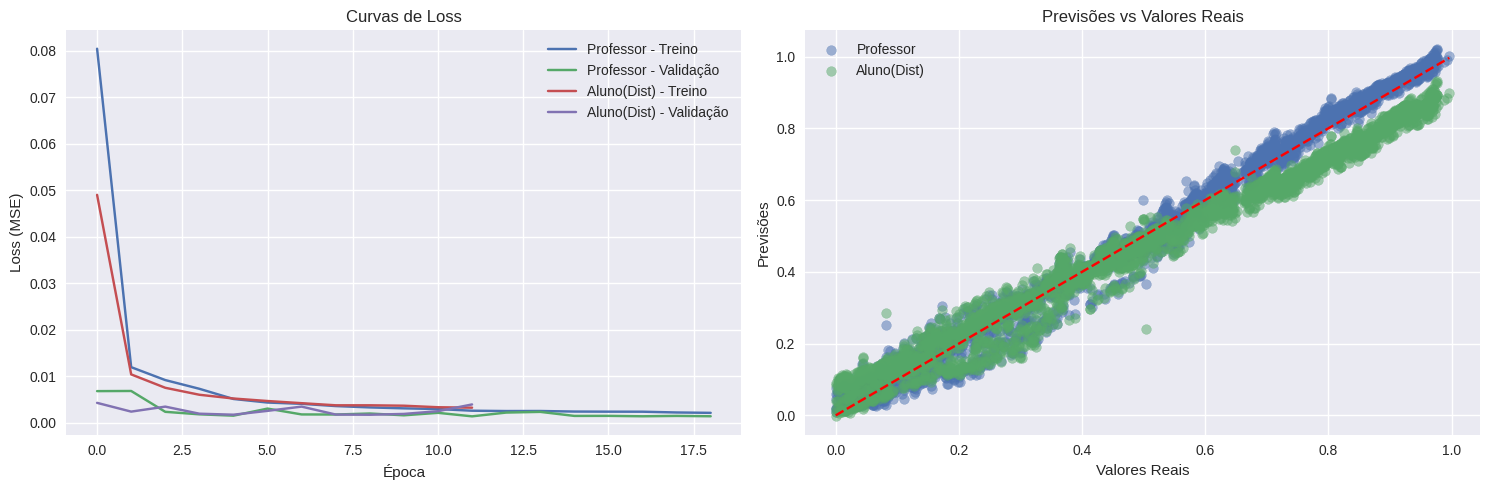


Tamanhos (na RAM, aproximado):
Teacher: 584.51 KB
Student(Dist): 52.80 KB
Razão de Compressão: 11.07x

Tamanhos (no disco, em .pth):
Teacher: 592.78 KB
Student(Dist): 57.51 KB

Tamanho do modelo Aluno Quantizado (no disco): 26.67 KB


In [ ]:
def clean_dataset(df):
    print("Tamanho original do dataset:", len(df))
    
    stats = df.describe()
    
    # Definir limites de IQR para algumas colunas
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Time constant current (s)', 
        'Charging time (s)'
    ]
    
    df_clean = df.copy()
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) &
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Tamanho após remoção de anomalias:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    # Criando novas features
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    # Tratar infinito e NaN
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    # Criar bins para RUL
    df = df.copy()
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    # Encontrar o tamanho da menor classe
    min_size = df.groupby('RUL_bin').size().min()
    
    # Amostragem balanceada
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    df_balanced = pd.concat(balanced_samples).drop('RUL_bin', axis=1)
    df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)
    
    print("\nTamanho do dataset após balanceamento:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    # Definir quais colunas usar como features
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency',
        'voltage_decay_rate', 
        'charging_speed'
    ]
    
    X = df[features].values
    y = df['RUL'].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Iniciando processamento do dataset...")
    
    print("\nEtapa 1: Limpeza dos dados")
    df_clean = clean_dataset(df)
    
    print("\nEtapa 2: Criação de novas features")
    df_featured = create_features(df_clean)
    new_cols = set(df_featured.columns) - set(df_clean.columns)
    print("Novas features criadas:", list(new_cols))
    
    print("\nEtapa 3: Balanceamento do dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    print("\nEtapa 4: Preparação dos dados (escalonamento)")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    print("\nEtapa 5: Divisão treino/teste")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y


class TeacherModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(TeacherModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, 
                            batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size*2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        # x: (batch_size, input_size)
        # LSTM espera (batch_size, seq_len, input_size). Vamos fingir seq_len=1
        x = x.unsqueeze(1)  # (batch_size, 1, input_size)
        
        lstm_out, _ = self.lstm(x)  # (batch_size, 1, 2*hidden_size)
        lstm_out = lstm_out[:, -1, :]  # (batch_size, 2*hidden_size)
        
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size=48):
        super(StudentModel, self).__init__()
        # Exemplo de "peso" que ajustaria cada feature antes de entrar no LSTM
        self.feature_weights = nn.Parameter(torch.ones(input_size))
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        # x: (batch_size, input_size)
        # Ajuste por feature_weights
        x = x * self.feature_weights  
        
        # LSTM espera (batch_size, seq_len, input_size)
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        
        # Pega a última saída do LSTM
        lstm_out = lstm_out[:, -1, :]
        
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
            self.counter = 0
            
    def restore(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            predictions.extend(outputs.numpy().flatten())
            targets.extend(target.numpy().flatten())
    return total_loss / len(dataloader), predictions, targets

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs,
                scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Treinamento "padrão", usado aqui para o Professor.
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(model)
                break
                
    return (train_losses, val_losses)

def train_student_with_distillation(student, teacher, train_loader, val_loader, 
                                    criterion, alpha, optimizer, epochs,
                                    scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Treinamento do Aluno com distilação do Professor:
    loss_final = alpha*MSE(Aluno, Rótulo) + (1-alpha)*MSE(Aluno, Professor)
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']

    teacher.eval()
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        student.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_pred = teacher(inputs)
            
            student_pred = student(inputs)
            
            loss_supervised = criterion(student_pred, targets)
            loss_distill = criterion(student_pred, teacher_pred)
            
            loss = alpha * loss_supervised + (1 - alpha) * loss_distill
            
            loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(student, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"[Distillation] Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, student)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(student)
                break
                
    return (train_losses, val_losses)


battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')

X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

# Salvar scalers
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

df_tmp = create_features(clean_dataset(battery_data))
correlations = df_tmp.corr()['RUL'].sort_values()
print("\nCorrelações com RUL (incluindo novas features):")
print(correlations)

np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)



X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



input_size = X_train.shape[1]
criterion = nn.MSELoss()

teacher = TeacherModel(input_size)
teacher_optimizer = optim.Adam(teacher.parameters(), lr=0.0005)
teacher_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    teacher_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)
early_stopping_teacher = EarlyStopping(patience=7, restore_best_weights=True)

print("\nTreinando modelo Professor...\n")
teacher_losses = train_model(
    model=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=teacher_optimizer,
    epochs=50,
    scheduler=teacher_scheduler,
    early_stopping=early_stopping_teacher,
    warmup_epochs=3
)



student = StudentModel(input_size)
student_optimizer = optim.Adam(student.parameters(), lr=0.0005)
student_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    student_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)
early_stopping_student = EarlyStopping(patience=7, restore_best_weights=True)

alpha = 0.7  # Peso da loss supervisionada vs. distilada

print(f"\nTreinando modelo Aluno com distilação (alpha={alpha})...\n")
student_losses = train_student_with_distillation(
    student=student,
    teacher=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    alpha=alpha,
    optimizer=student_optimizer,
    epochs=50,
    scheduler=student_scheduler,
    early_stopping=early_stopping_student,
    warmup_epochs=3
)


print("\nAvaliando modelos...")
teacher_loss, teacher_pred, teacher_true = evaluate_model(teacher, test_loader, criterion)
student_loss, student_pred, student_true = evaluate_model(student, test_loader, criterion)

print(f"Loss final do Professor: {teacher_loss:.4f}")
print(f"Loss final do Aluno (Distilado): {student_loss:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(teacher_losses[0], label='Professor - Treino')
plt.plot(teacher_losses[1], label='Professor - Validação')
plt.plot(student_losses[0], label='Aluno(Dist) - Treino')
plt.plot(student_losses[1], label='Aluno(Dist) - Validação')
plt.title('Curvas de Loss')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(teacher_true, teacher_pred, alpha=0.5, label='Professor')
plt.scatter(student_true, student_pred, alpha=0.5, label='Aluno(Dist)')
min_val = min(teacher_true + student_true)
max_val = max(teacher_true + student_true)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Previsões vs Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.legend()

plt.tight_layout()
plt.show()


def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_kb = (param_size + buffer_size) / 1024
    return size_kb

def get_model_disk_size(model, path="temp.pth"):
    torch.save(model.state_dict(), path)
    size_kb = os.path.getsize(path) / 1024
    os.remove(path)
    return size_kb

teacher_size = get_model_size(teacher)
student_size = get_model_size(student)
print("\nTamanhos (na RAM, aproximado):")
print(f"Teacher: {teacher_size:.2f} KB")
print(f"Student(Dist): {student_size:.2f} KB")
print(f"Razão de Compressão: {teacher_size / student_size:.2f}x")

teacher_disk = get_model_disk_size(teacher, "teacher_temp.pth")
student_disk = get_model_disk_size(student, "student_temp.pth")
print("\nTamanhos (no disco, em .pth):")
print(f"Teacher: {teacher_disk:.2f} KB")
print(f"Student(Dist): {student_disk:.2f} KB")

def quantize_student_model(student_model, data_loader):
    """
    Exemplo de quantização estática pós-treinamento.
    Em LSTMs, normalmente não funciona bem sem modificações adicionais.
    Mas segue um exemplo simples de quantizar as camadas lineares.
    """
    # Copia do modelo
    model_to_quant = StudentModel(input_size)
    model_to_quant.load_state_dict(student_model.state_dict())
    model_to_quant.eval()

    # Definir configuração de quantização (APENAS para camadas lineares)
    model_to_quant.qconfig = torch.quantization.default_qconfig
    
    # Prepara (inplace=False retorna outro modelo)
    model_prepared = torch.quantization.prepare(model_to_quant, inplace=False)
    
    # Loop de calibração
    with torch.no_grad():
        for inputs, _ in data_loader:
            model_prepared(inputs)
    
    # Converte para modelo quantizado
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)
    
    return model_quantized

student_quantized = quantize_student_model(student, train_loader)
torch.save(student_quantized.state_dict(), "student_quantized.pth")

quant_disk_size = get_model_disk_size(student_quantized, "quantized_temp.pth")
print(f"\nTamanho do modelo Aluno Quantizado (no disco): {quant_disk_size:.2f} KB")


In [ ]:
def process_new_data_for_inference(df_new, scaler_X):
    """
    Aplica o mesmo pipeline de limpeza e feature engineering,
    mas NÃO faz balanceamento e NÃO refaz fit do scaler.
    
    Returns: X_infer (scaled numpy array)
    """  
    # df_clean = clean_dataset(df_new)
    
    df_featured = create_features(df_new)
    # df_featured = create_features(df_clean)
    
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency', 
        'voltage_decay_rate', 
        'charging_speed'
    ]
    X_new = df_featured[features].values
    
    X_infer = scaler_X.transform(X_new)
    
    return X_infer, df_featured  # df_featured



In [ ]:
def predict_rul_in_pipeline(df_novo):
    """
    Full inference pipeline for new data 'df_novo'
    (without resampling, but with the same transformations).
    Returns RUL predictions and the resulting DataFrame.
    """
    scaler_X = joblib.load("scaler_X.pkl")
    scaler_y = joblib.load("scaler_y.pkl")
    
    input_size = 11 
    model = StudentModel(input_size=input_size)
    state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")
    model.load_state_dict(state_dict)
    model.eval()
    
    X_infer, df_feat = process_new_data_for_inference(df_novo, scaler_X)
    X_tensor = torch.FloatTensor(X_infer)
    
    with torch.no_grad():
        pred_scaled = model(X_tensor)
    
    pred_np = pred_scaled.numpy().reshape(-1, 1)
    rul_pred = scaler_y.inverse_transform(pred_np).ravel()
    rul_pred = np.clip(rul_pred, a_min=0, a_max=None)
    
    df_feat["RUL_pred"] = rul_pred
    
    return rul_pred, df_feat


if __name__ == "__main__":
    # (must contain at least: Discharge Time (s), Decrement 3.6-3.4V (s), etc.)
#     df_novo = pd.DataFrame({
#     "Cycle_Index": [362, 610],
#     "Discharge Time (s)": [5500, 5800],
#     "Decrement 3.6-3.4V (s)": [950, 1000],
#     "Max. Voltage Dischar. (V)": [4.07, 4.05],
#     "Min. Voltage Charg. (V)": [3.35, 3.33],
#     "Time at 4.15V (s)": [2300, 2100],
#     "Time constant current (s)": [3600, 3700],
#     "Charging time (s)": [6000, 6150],
#     # RUL apenas para referência 
#     "RUL": [750, 700]
# })

#     df_novo = pd.DataFrame({
#     "Cycle_Index": [28.000000],
#     "Discharge Time (s)": [2234.380000],
#     "Decrement 3.6-3.4V (s)": [852.000000],
#     "Max. Voltage Dischar. (V)": [4.045000],
#     "Min. Voltage Charg. (V)": [3.378000],
#     "Time at 4.15V (s)": [5118.368000],
#     "Time constant current (s)": [6091.360000],
#     "Charging time (s)": [9176.380000],
#     "RUL": [1085.000000]
# })
    
    df_novo = pd.DataFrame({
    "Cycle_Index": [599.000000],
    "Discharge Time (s)": [1545.880000],
    "Decrement 3.6-3.4V (s)": [463.125000],
    "Max. Voltage Dischar. (V)": [3.910000],
    "Min. Voltage Charg. (V)": [3.744000],
    "Time at 4.15V (s)": [2807.250000],
    "Time constant current (s)": [3752.000000],
    "Charging time (s)": [8415.620000],
    "RUL": [514.000000]
})


    # Predict
    rul_pred, df_pred = predict_rul_in_pipeline(df_novo)
    # rul_pred_clamped = np.clip(rul_pred, 0, 1112)  


    print("Predições de RUL:", rul_pred)
    print(df_pred)


Predições de RUL: [538.9088]
   Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0        599.0             1545.88                 463.125   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                       3.91                    3.744            2807.25   

   Time constant current (s)  Charging time (s)    RUL  voltage_range  \
0                     3752.0            8415.62  514.0          0.166   

   charging_efficiency  voltage_decay_rate  charging_speed    RUL_pred  
0             5.443903            0.299587        0.445838  538.908813  


/tmp/ipykernel_383899/3845991306.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")


In [18]:
from evaluation import evaluate_model

# Avaliar modelo Professor
teacher_metrics = evaluate_model(teacher, test_loader, criterion)

# Avaliar modelo Aluno
student_metrics = evaluate_model(student, test_loader, criterion)

print("\nModel Comparison:")
print("Teacher vs Student Performance:")
print(f"Teacher Overall MSE: {teacher_metrics['overall']['mse']:.4f}")
print(f"Student Overall MSE: {student_metrics['overall']['mse']:.4f}")
print(f"Size Reduction: {100*(1 - student_size/teacher_size):.1f}%")


=== Métricas Gerais ===
MSE: 0.0014
MAE: 0.0293
R²: 0.9827

=== Métricas por Faixa de RUL ===

Faixa 0-10:
Amostras: 2903
MAE: 0.0293
Erro Médio: 0.0066

=== Análise de Erros ===
Erro Médio: 0.0066
Desvio Padrão do Erro: 0.0370
% de Predições Outliers: 5.79%

=== Métricas Gerais ===
MSE: 0.0040
MAE: 0.0534
R²: 0.9514

=== Métricas por Faixa de RUL ===

Faixa 0-10:
Amostras: 2903
MAE: 0.0534
Erro Médio: -0.0296

=== Análise de Erros ===
Erro Médio: -0.0296
Desvio Padrão do Erro: 0.0555
% de Predições Outliers: 0.07%

Model Comparison:
Teacher vs Student Performance:
Teacher Overall MSE: 0.0014
Student Overall MSE: 0.0040
Size Reduction: 91.0%
